# LSTM Encoder-Decoder


In [1]:
!nvidia-smi

Thu Jan  5 07:37:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparing Data sets

Import Google Drive

In [2]:
# import google drive
from google.colab import drive

# mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load dataset from Google Drive

In [3]:
# If LOAD_NPY = True, npy file will be loaded instead of .mat files
LOAD_NPY = False

# import packages
import shutil

if LOAD_NPY:
  dest = '/content/'                                      # this is in the colab VM
  drive_src = '/content/drive/MyDrive/datasets/NASA/'     # location from GDrive (folder)
  src = drive_src + "NASA.npy"                            # Specify file name
  print(f"Copying {src} to {dest}")                       
  shutil.copy(src,dest)                                   # Copy to dest
else:
  # create folder for destination path
  from pathlib import Path
  Path("datasets/NASA/").mkdir(parents=True, exist_ok=True)

  # define paths
  dest = '/content/datasets/NASA/'                        # this is in the colab VM
  drive_src = '/content/drive/MyDrive/datasets/NASA/'     # location from GDrive (folder)

  # copy to dest
  for filename in ['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat']:
    src = drive_src + filename
    print(f"Copying {src} to {dest}")
    shutil.copy(src,dest)

Copying /content/drive/MyDrive/datasets/NASA/B0005.mat to /content/datasets/NASA/
Copying /content/drive/MyDrive/datasets/NASA/B0006.mat to /content/datasets/NASA/
Copying /content/drive/MyDrive/datasets/NASA/B0007.mat to /content/datasets/NASA/
Copying /content/drive/MyDrive/datasets/NASA/B0018.mat to /content/datasets/NASA/


## Import Packages

In [4]:
#Import modules
import numpy as np
import random
import math
import os 
import sys
import copy
import scipy.io 
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Setting up device-agnostic code

In [5]:
# Setting up device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data processing

In [6]:
# convert str to datatime 
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [7]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

if LOAD_NPY:
  # If the original data set cannot be read successfully, you can simply load the data already extracted: NASA.npy
  Battery = np.load('NASA.npy', allow_pickle=True)
  Battery = Battery.item()
else:
  Battery = {}
  for name in Battery_list:
      print('Load Dataset ' + name + '.mat ...')
      path = dir_path + name + '.mat'
      data = loadMat(path)
      Battery[name] = getBatteryCapacity(data)
  np.save('datasets/NASA/NASA.npy', Battery, allow_pickle=True)

Load Dataset B0005.mat ...
Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


## Plot the Dataset

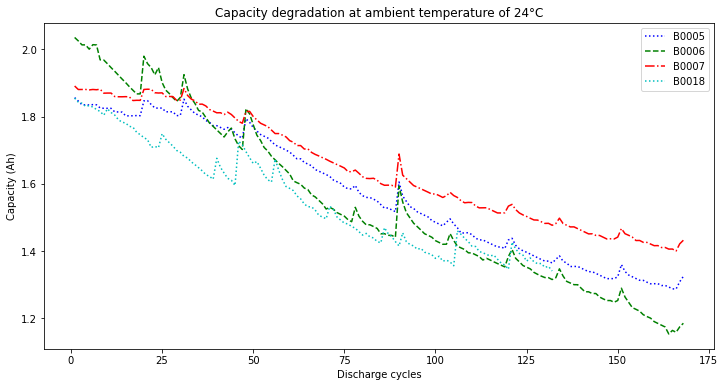

In [8]:
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

## LSTM Encoder-Decoder Architecture

In [9]:
import numpy as np
import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [10]:
class LSTM_ENCODER(nn.Module):
    def __init__(self, input_size, hidden_size, device, num_layers = 1):
        super(LSTM_ENCODER, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # define LSTM Layer
        self.lstm = nn.LSTM(input_size =  input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
    
    def forward(self, x_input):
        # x_input -- input of shape(sequence_length, # in batch, input_size)
        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))

        return lstm_out, self.hidden
    def init_hidden(self, batch_size):
        # batch_size = x_input.shape[1]
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        
class LSTM_DECODER(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTM_DECODER, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        # x_input  should be 2D(batch_size, input_size)
        # encoder_hidden_states hidden states
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))

        return output, self.hidden

class LSTMSequential(nn.Module):
    ''' train and LSTM encoder-decoder and make predictions '''
    def __init__(self, input_size, hidden_size):
        super(LSTMSequential, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device

        self.encoder = LSTM_ENCODER(input_size = input_size, device=self.device, hidden_size = hidden_size)
        self.decoder = LSTM_DECODER(input_size = input_size, hidden_size = hidden_size)

    def train_model(self,
                    input_tensor,
                    target_tensor,
                    n_epochs,
                    target_len,
                    batch_size,
                    device,
                    seed,
                    training_prediction = 'recursive',
                    teacher_forcing_ratio = 0.5,
                    learning_rate = 0.01, dynamic_tf = False):
        '''
        
        train lstm encoder-decoder
        
        '''
        # setup seed
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # initialize array of losses
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:

                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2], device=device)

                    # initialize hidden_state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output
                    
                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively
                        else:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output
                    
                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output

                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]

                            #predict recursively
                            else:
                                decoder_input = decoder_output

                    # compute the loss
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch
                batch_loss /= n_batches
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02

                # progress bar
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))
            
        return losses

    def predict(self, input_tensor, target_len):
        '''
        
        make test predictions

        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)       # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output

        np_outputs = outputs.detach().numpy()

        return np_outputs


## Train models for each Battery

### De-trending the time series

In [11]:
def DetrendDifferencing(cap_dict, name):
    detrended_capacity = {}
    df = copy.deepcopy(cap_dict[name][1])
    diff = list()
    for i in range(1, len(df)):
        value = df[i] - df[i-1]
        diff.append(value)
    #detrended_capacity[name] = diff 
    return diff

In [12]:
detrended = {}
for item in Battery_list:
  detrended[item] = DetrendDifferencing(cap_dict=Battery, name=item)

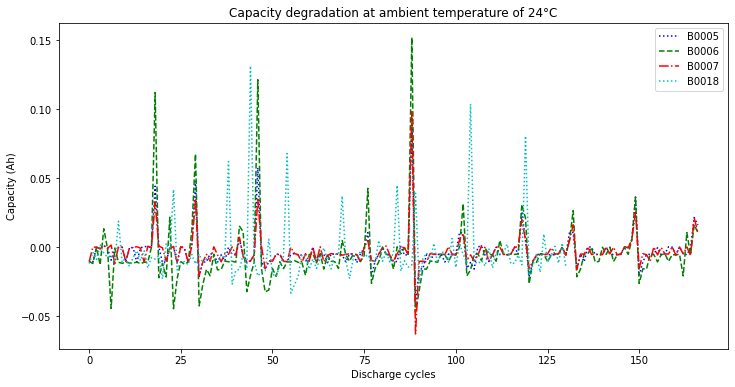

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battery_list, color_list):
    #df_result_orig = Battery[name]
    df_result_detrended = detrended[name]
    ax.plot(df_result_detrended, color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [ ]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

scaler={}
normalized={}
for item in Battery_list:
  scaler[item] = StandardScaler()
  scaler[item] = scaler[item].fit(np.array(detrended[item]).reshape(-1, 1))
  print('Mean: %f, StandardDeviation: %f' % (scaler[item].mean_, sqrt(scaler[item].var_)))
  normalized[item] = scaler[item].transform(np.array(detrended[item]).reshape(-1, 1))
  print(normalized[item].shape)

Mean: -0.003182, StandardDeviation: 0.012898
(167, 1)
Mean: -0.005088, StandardDeviation: 0.023033
(167, 1)
Mean: -0.002746, StandardDeviation: 0.012106
(167, 1)
Mean: -0.003923, StandardDeviation: 0.022263
(131, 1)


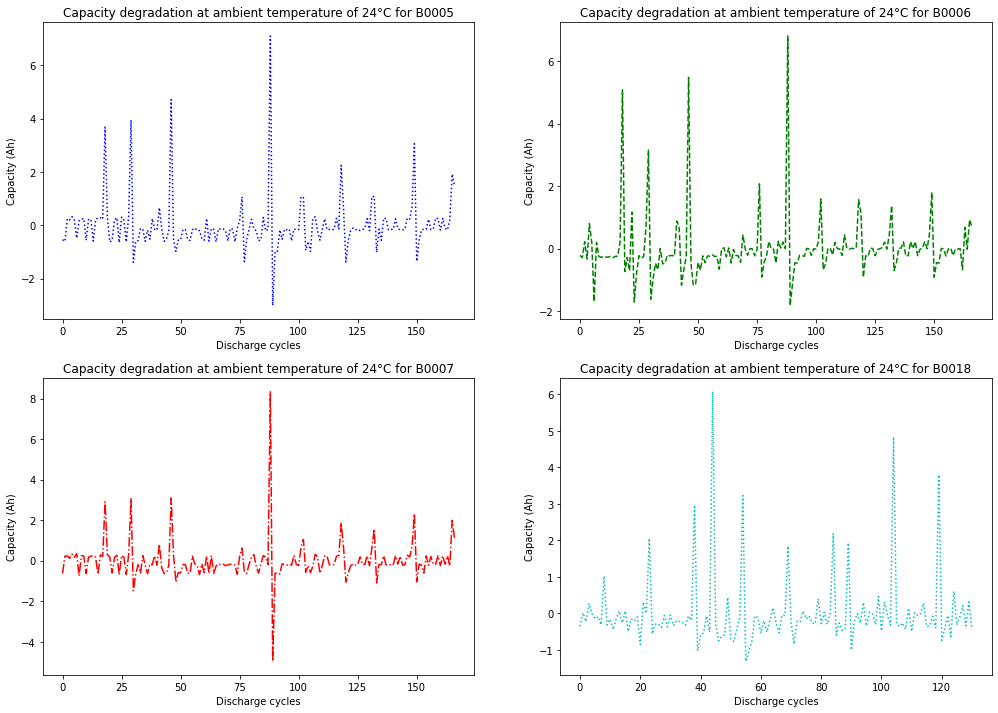

In [ ]:
plt.figure(figsize=(17,12))
i=0
for item, color in zip(Battery_list,color_list):
  plt.subplot(2,2,i+1)
  df_result = normalized[item]
  x = list(range(0, len(df_result)))
  plt.plot(x, df_result, color, label=item)
  plt.xlabel('Discharge cycles') 
  plt.ylabel('Capacity (Ah)')
  plt.title(f'Capacity degradation at ambient temperature of 24°C for {item}')
  #plt.legend()
  i=i+1

### Building the data sequences

In [ ]:
def train_test_split(normalize, split = 0.6):
    '''

    split time series into train/test sets
    param normalize:            normalized detrended capacity time series data
    param split:                percent of data to include in training set
    return x_train, x_test:     feature training and test sets

    '''
    indx_split = round(split * len(normalize))
    indx_train = np.arange(0, indx_split)
    indx_test = np.arange(indx_split, len(normalize))

    x_train = normalize[indx_train]
    x_train = x_train.reshape(-1,1)

    x_test = normalize[indx_test]
    x_test = x_test.reshape(-1,1)

    return x_train, x_test

In [ ]:
x_train, x_test = {}, {}
for item in Battery_list:
  x_train[item], x_test[item] = train_test_split(normalize=normalized[item])
  print(f"{item}: {x_train[item].shape}, {x_test[item].shape}")

B0005: (100, 1), (67, 1)
B0006: (100, 1), (67, 1)
B0007: (100, 1), (67, 1)
B0018: (79, 1), (52, 1)


In [ ]:
def get_x_y_pairs(x, train_period = 5, prediction_period = 1, stride = 1, num_features = 1):
    '''

    create x, y pairs by windowing
        x:                      time series feature (array)
        train_period:           number of x samples to give model
        prediction_period:      number of future x samples to predict
        stride:                 spacing between windows
        num_features:           number of features (for this project, we only have 1 feature)
        return X, Y:            arrays with correct dimensions for LSTM
    
    '''

    Length = x.shape[0]
    num_samples = (Length - train_period - prediction_period) // stride + 1

    X = np.zeros([train_period, num_samples, num_features])
    Y = np.zeros([prediction_period, num_samples, num_features])

    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            init_x = stride * ii
            fin_x = init_x + train_period
            X[:, ii, ff] = x[init_x:fin_x, ff]

            init_y = stride * ii + train_period
            fin_y = init_y + prediction_period
            Y[:, ii, ff] = x[init_y:fin_y, ff]
    
    return X, Y

In [ ]:
X_train, Y_train = {}, {}
X_test, Y_test = {}, {}
input_window = 16
output_window = 8
stride = 1

for item in Battery_list: 
  X_train[item], Y_train[item] = get_x_y_pairs(x_train[item],
                                  train_period = input_window,
                                  prediction_period = output_window,
                                  stride = stride,
                                  num_features = 1)

  X_test[item], Y_test[item] = get_x_y_pairs(x_test[item],
                                  train_period = input_window,
                                  prediction_period = output_window,
                                  stride = stride,
                                  num_features = 1)

  print(f"{item}: {X_train[item].shape}, {Y_train[item].shape}, {X_test[item].shape}, {Y_test[item].shape}")

B0005: (16, 10, 1), (8, 10, 1), (16, 6, 1), (8, 6, 1)
B0006: (16, 10, 1), (8, 10, 1), (16, 6, 1), (8, 6, 1)
B0007: (16, 10, 1), (8, 10, 1), (16, 6, 1), (8, 6, 1)
B0018: (16, 7, 1), (8, 7, 1), (16, 4, 1), (8, 4, 1)


In [ ]:
def numpy_to_torch(X_train, Y_train, X_test, Y_test):
    '''
    convert numpy array to PyTorch tensor

    '''

    X_train_torch = torch.from_numpy(X_train).type(torch.Tensor)
    Y_train_torch = torch.from_numpy(Y_train).type(torch.Tensor)
    
    X_test_torch = torch.from_numpy(X_test).type(torch.Tensor)
    Y_test_torch = torch.from_numpy(Y_test).type(torch.Tensor)

    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

In [ ]:
X_train_torch, Y_train_torch = {}, {}
X_test_torch, Y_test_torch = {}, {}

for item in Battery_list:
  X_train_torch[item], Y_train_torch[item], X_test_torch[item], Y_test_torch[item] = numpy_to_torch(X_train[item],
                                                                            Y_train[item],
                                                                            X_test[item],
                                                                            Y_test[item])

### Training the models

In [ ]:
models = {}

In [ ]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
CONTINUE_TRAIN = False
for lr in [0.001,0.0005, 0.0001, 5e-5]:
  print(f"lr={lr}")
  for item in Battery_list:
    if CONTINUE_TRAIN==False:
      print(f"Instantiating Model {item}...")
      models[item] = LSTMSequential(input_size = X_train_torch[item].shape[2], hidden_size = 16)
    
    print(f"Training Model {item}...")
    loss = models[item].train_model(X_train_torch[item], Y_train_torch[item],
                            n_epochs = 300,
                            target_len = 8,
                            batch_size = 5,
                            training_prediction = 'mixed_teacher_forcing',
                            teacher_forcing_ratio=0.6,
                            learning_rate = lr,
                            dynamic_tf = False)
  CONTINUE_TRAIN = True
  print("\n")
  print("-"*64)

lr=0.001
Instantiating Model B0005...
Training Model B0005...


100%|██████████| 300/300 [00:08<00:00, 35.38it/s, loss=0.338]


Instantiating Model B0006...
Training Model B0006...


100%|██████████| 300/300 [00:08<00:00, 37.05it/s, loss=0.303]


Instantiating Model B0007...
Training Model B0007...


100%|██████████| 300/300 [00:07<00:00, 38.35it/s, loss=0.110]


Instantiating Model B0018...
Training Model B0018...


100%|██████████| 300/300 [00:04<00:00, 61.81it/s, loss=0.482]




----------------------------------------------------------------
lr=0.0005
Training Model B0005...


100%|██████████| 300/300 [00:14<00:00, 20.44it/s, loss=0.133]


Training Model B0006...


100%|██████████| 300/300 [00:07<00:00, 37.83it/s, loss=0.097]


Training Model B0007...


100%|██████████| 300/300 [00:07<00:00, 37.90it/s, loss=0.027]


Training Model B0018...


100%|██████████| 300/300 [00:04<00:00, 62.42it/s, loss=0.205]




----------------------------------------------------------------
lr=0.0001
Training Model B0005...


100%|██████████| 300/300 [00:07<00:00, 37.84it/s, loss=0.095]


Training Model B0006...


100%|██████████| 300/300 [00:11<00:00, 26.11it/s, loss=0.111]


Training Model B0007...


100%|██████████| 300/300 [00:07<00:00, 38.63it/s, loss=0.022]


Training Model B0018...


100%|██████████| 300/300 [00:06<00:00, 45.74it/s, loss=0.163]




----------------------------------------------------------------
lr=5e-05
Training Model B0005...


100%|██████████| 300/300 [00:14<00:00, 20.59it/s, loss=0.084]


Training Model B0006...


100%|██████████| 300/300 [00:17<00:00, 17.56it/s, loss=0.099]


Training Model B0007...


100%|██████████| 300/300 [00:09<00:00, 30.79it/s, loss=0.021]


Training Model B0018...


100%|██████████| 300/300 [00:04<00:00, 63.69it/s, loss=0.140]



----------------------------------------------------------------


### Model eval

In [ ]:
def retrend_function(Batt_Val, denormalize, name = 'B0005', split_ratio = '0.6'):
    final = []
    idx_lastpoint = int(len(Batt_Val[name][1])*0.6) - 1
    past_val = Batt_Val[name][1][idx_lastpoint]
    for i in range(len(denormalize)):
        pres_val = past_val + denormalize[i]
        final.append(pres_val)
        past_val = pres_val
    return final

In [ ]:
final_output={}
for item in Battery_list:
  #print(f"{'='*10}\n{item}\n{'='*10}")
  models[item].eval()
  output_len = len(x_test[item]) 
  outputs = np.empty((0,output_len))
  with torch.no_grad():
      xl = len(x_train[item])
      train_period = input_window
      dict_res = x_train[item]
      x = dict_res[xl-train_period: xl]   
     
      outputs_len = output_len + (output_window-(output_len%output_window))
      
      while len(outputs) < outputs_len:
          Y_test_pred = models[item].predict(torch.from_numpy(x).type(torch.Tensor), target_len = output_window)
          outputs = np.concatenate((outputs, Y_test_pred), axis=None)
          x = x[8:16]
          x = np.append(x, [Y_test_pred])
          x = x.reshape(-1,1)
  new_outputs = outputs[0:output_len+1]
  denormalize = scaler[item].inverse_transform(np.array(new_outputs).reshape(-1, 1))
  final_output[item] = retrend_function(Batt_Val=Battery, denormalize=denormalize, name=item)
  final_output[item] = np.concatenate(final_output[item],axis=0)

Metrics

In [ ]:
from timeit import default_timer as timer
import tracemalloc

# Compute for accuracy
def accuracy(y_test, y_pred, numpy=True):
  if numpy:
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
  else:
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
  
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

In [ ]:
for item in Battery_list:
  x, y = Battery[item]
  y_true = y[-len(final_output[item]):]
  y_preds = final_output[item]
  print(f"Metrics for Model {item}")
  acc = accuracy(np.array(y_true),np.array(y_preds))*100
  mae = mean_absolute_error(np.array(y_true),np.array(y_preds))
  rmse = sqrt(mean_squared_error(np.array(y_true),np.array(y_preds)))
  print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | Accuracy: {acc:.4f}")
  print("-"*50)

Metrics for Model B0005
MAE: 0.0852 | RMSE: 0.0946 | Accuracy: 93.6786
--------------------------------------------------
Metrics for Model B0006
MAE: 0.0717 | RMSE: 0.0846 | Accuracy: 94.3451
--------------------------------------------------
Metrics for Model B0007
MAE: 0.0402 | RMSE: 0.0494 | Accuracy: 97.2597
--------------------------------------------------
Metrics for Model B0018
MAE: 0.0850 | RMSE: 0.1073 | Accuracy: 93.8963
--------------------------------------------------


Plot the predictions vs ground truth

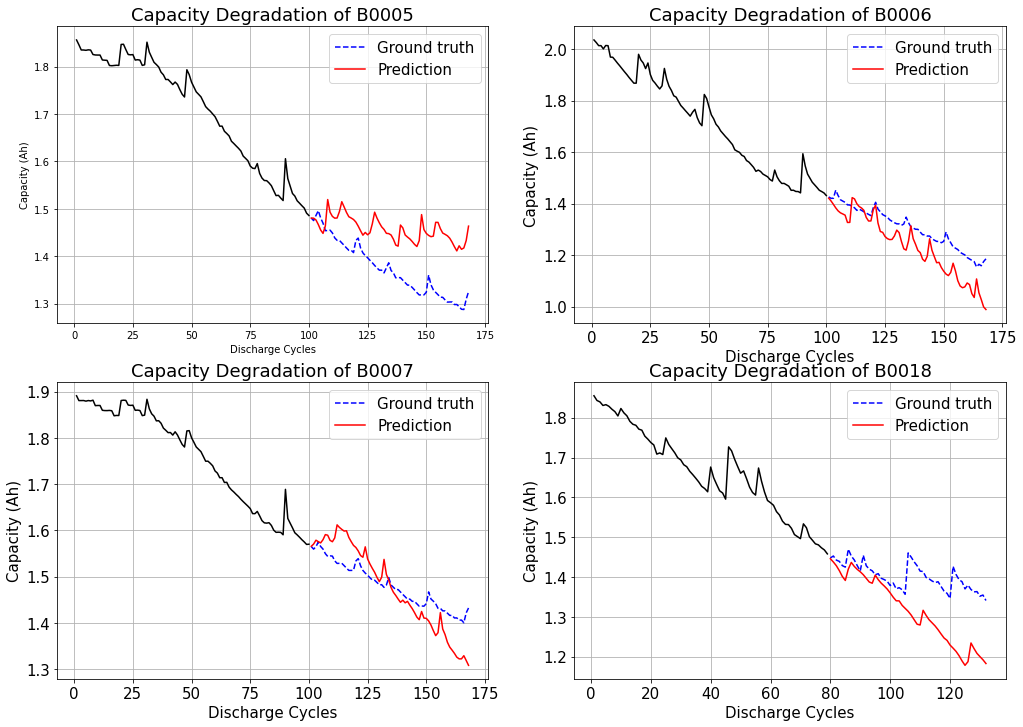

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(17,12))
i=1
for item in Battery_list:
  plt.subplot(2,2,i)
  #x = Battery['B0005'][0]
  #y = Battery['B0005'][1]
  x, y = Battery[item]
  font = {'size'   : 15}

  mpl.rc('font', **font)
  #fig = plt.figure(figsize=(10,5))
  plt.title(f'Capacity Degradation of {item}')
  plt.ylabel('Capacity (Ah)')
  plt.xlabel('Discharge Cycles')
  plt.grid(True)
  plt.plot(x[:-len(final_output[item])],
          y[:-len(final_output[item])],
          "k-")
  plt.plot(x[-len(final_output[item]):],
          y[-len(final_output[item]):],
          "b--",
          label='Ground truth')
  plt.plot(x[-len(final_output[item]):],
          final_output[item],
          "r-",
          label='Prediction')
  plt.legend()
  i=i+1
plt.savefig(f'plot', dpi=200)

## Train Model on 3 batteries, test on 1

### De-trending the time series

In [11]:
def DetrendDifferencing(cap_dict, name):
    detrended_capacity = {}
    df = copy.deepcopy(cap_dict[name][1])
    diff = list()
    for i in range(1, len(df)):
        value = df[i] - df[i-1]
        diff.append(value)
    #detrended_capacity[name] = diff 
    return diff

In [12]:
detrended = {}
for item in Battery_list:
  detrended[item] = DetrendDifferencing(cap_dict=Battery, name=item)

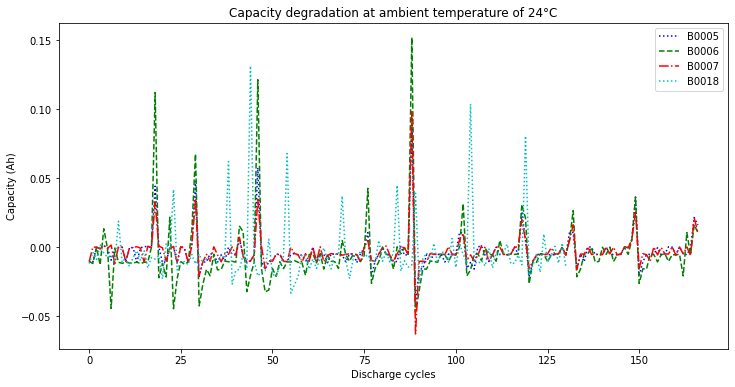

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battery_list, color_list):
    #df_result_orig = Battery[name]
    df_result_detrended = detrended[name]
    ax.plot(df_result_detrended, color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

In [15]:
from sklearn.preprocessing import StandardScaler
import joblib
from math import sqrt

scaler={}
normalized={}
for item in Battery_list:
  scaler[item] = StandardScaler()
  scaler[item] = scaler[item].fit(np.array(detrended[item]).reshape(-1, 1))
  print('Mean: %f, StandardDeviation: %f' % (scaler[item].mean_, sqrt(scaler[item].var_)))
  normalized[item] = scaler[item].transform(np.array(detrended[item]).reshape(-1, 1))
  print(normalized[item].shape)

# Save scaler
joblib.dump(scaler, 'scaler_LSTM_NASA.save') 

Mean: -0.003182, StandardDeviation: 0.012898
(167, 1)
Mean: -0.005088, StandardDeviation: 0.023033
(167, 1)
Mean: -0.002746, StandardDeviation: 0.012106
(167, 1)
Mean: -0.003923, StandardDeviation: 0.022263
(131, 1)


['scaler_LSTM_NASA.save']

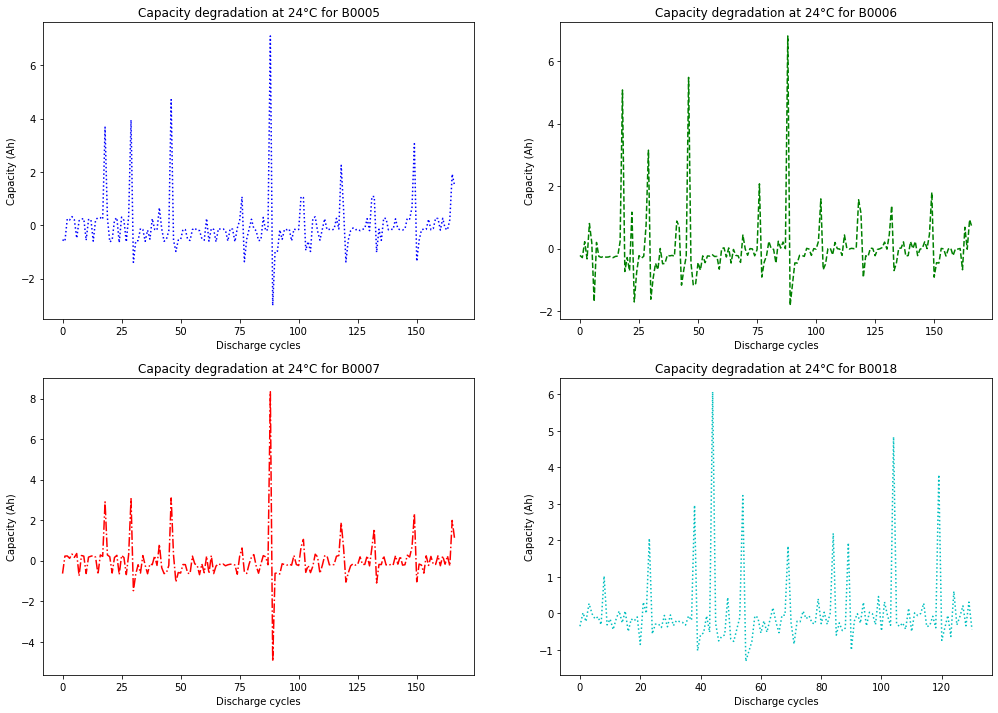

In [16]:
plt.figure(figsize=(17,12))
i=0
for item, color in zip(Battery_list,color_list):
  plt.subplot(2,2,i+1)
  df_result = normalized[item]
  x = list(range(0, len(df_result)))
  plt.plot(x, df_result, color, label=item)
  plt.xlabel('Discharge cycles') 
  plt.ylabel('Capacity (Ah)')
  plt.title(f'Capacity degradation at 24°C for {item}')
  #plt.legend()
  i=i+1

### Building the data sequences

Specify if detrending is to be performed

In [17]:
DETREND = True

In [18]:
def train_test_split(seq, split = 0.6):
    '''

    split time series into train/test sets
    param seq:                  capacity time series data
    param split:                percent of data to include in training set
    return x_train, x_test:     feature training and test sets

    '''
    indx_split = round(split * len(seq))
    indx_train = np.arange(0, indx_split)
    indx_test = np.arange(indx_split, len(seq))

    x_train = seq[indx_train]
    x_train = x_train.reshape(-1,1)

    x_test = seq[indx_test]
    x_test = x_test.reshape(-1,1)

    return x_train, x_test

In [19]:
def get_x_y_pairs(x, train_period = 5, prediction_period = 1, stride = 1, num_features = 1):
    '''

    create x, y pairs by windowing
        x:                      time series feature (array)
        train_period:           number of x samples to give model
        prediction_period:      number of future x samples to predict
        stride:                 spacing between windows
        num_features:           number of features (for this project, we only have 1 feature)
        return X, Y:            arrays with correct dimensions for LSTM
    
    '''

    Length = x.shape[0]
    num_samples = (Length - train_period - prediction_period) // stride + 1

    X = np.zeros([train_period, num_samples, num_features])
    Y = np.zeros([prediction_period, num_samples, num_features])

    for ff in np.arange(num_features):
        for ii in np.arange(num_samples):
            init_x = stride * ii
            fin_x = init_x + train_period
            X[:, ii, ff] = x[init_x:fin_x, ff]

            init_y = stride * ii + train_period
            fin_y = init_y + prediction_period
            Y[:, ii, ff] = x[init_y:fin_y, ff]
    
    return X, Y

In [20]:
def numpy_to_torch(X_train, Y_train, X_test, Y_test, device, mode='Train'):
    '''
    convert numpy array to PyTorch tensor
    Modes:
    Train - only train arrays
    Test - only test arrays
    Both - both train and test arrays

    ''' 

    X_train_torch = torch.from_numpy(X_train).type(torch.Tensor)
    Y_train_torch = torch.from_numpy(Y_train).type(torch.Tensor)
    
    if(mode=='Train'):
      X_test_torch = torch.empty((1,1))
      Y_test_torch = torch.empty((1,1))
    else:
      X_test_torch = torch.from_numpy(X_test).type(torch.Tensor)
      Y_test_torch = torch.from_numpy(Y_test).type(torch.Tensor)

    X_train_torch, Y_train_torch = X_train_torch.to(device), Y_train_torch.to(device)
    X_test_torch, Y_test_torch = X_test_torch.to(device), Y_test_torch.to(device)

    return X_train_torch, Y_train_torch, X_test_torch, Y_test_torch

In [21]:
# Dict for Train-Test Split
Train_list = {}
x_train, x_test = {}, {}


# Dict for Get X-Y Pairs
X_train, Y_train = {}, {}
X_test, Y_test = {}, {}
# Parameters for X-Y Pairs
input_window = 16
output_window = 16
stride = 1

# Dict for Convert to torch
X_train_torch, Y_train_torch = {}, {}
X_test_torch, Y_test_torch = {}, {}

for leave_out in Battery_list:
  Train_list[leave_out] = Battery_list.copy()
  Train_list[leave_out].pop(Train_list[leave_out].index(leave_out))
  print(f"Train: {Train_list[leave_out]}")
  print(f"Test: {[leave_out]}\n")

  x_train[leave_out], x_test[leave_out] = {}, {}

  # Get train test split

  if DETREND:
    for item in Train_list[leave_out]:
      x_train[leave_out][item], x_test[leave_out][item] = train_test_split(seq=normalized[item], split=1)
      print(f"Train {item}: {x_train[leave_out][item].shape}, {x_test[leave_out][item].shape}")

    for item in [leave_out]:
      x_train[leave_out][item], x_test[leave_out][item] = train_test_split(seq=normalized[item], split=0.6)
      print(f"Test {item}: {x_train[leave_out][item].shape}, {x_test[leave_out][item].shape}")
  else:
    for item in Train_list[leave_out]:
      x_train[leave_out][item], x_test[leave_out][item] = train_test_split(seq=np.array(Battery[item][1]), split=1)
      print(f"Train {item}: {x_train[leave_out][item].shape}, {x_test[leave_out][item].shape}")

    for item in [leave_out]:
      x_train[leave_out][item], x_test[leave_out][item] = train_test_split(seq=np.array(Battery[item][1]), split=0.6)
      print(f"Test {item}: {x_train[leave_out][item].shape}, {x_test[leave_out][item].shape}")

  X_train[leave_out], Y_train[leave_out] = {}, {}
  X_test[leave_out], Y_test[leave_out] = {}, {}
  print("")

  # Get X-Y Pairs

  for item in Battery_list: 
    X_train[leave_out][item], Y_train[leave_out][item] = get_x_y_pairs(x_train[leave_out][item],
                                                          train_period = input_window,
                                                          prediction_period = output_window,
                                                          stride = stride,
                                                          num_features = 1)
    print(f"Train {item}: {X_train[leave_out][item].shape}, {Y_train[leave_out][item].shape}")

  for item in [leave_out]:
    X_test[leave_out][item], Y_test[leave_out][item] = get_x_y_pairs(x_test[leave_out][item],
                                                        train_period = input_window,
                                                        prediction_period = output_window,
                                                        stride = stride,
                                                        num_features = 1)
    print(f"Test {item}: {X_test[leave_out][item].shape}, {Y_test[leave_out][item].shape}")

  # Convert to Torch Tensor

  X_train_torch[leave_out], Y_train_torch[leave_out] = {}, {}
  X_test_torch[leave_out], Y_test_torch[leave_out] = {}, {}

  for item in Train_list[leave_out]:
    X_train_torch[leave_out][item], Y_train_torch[leave_out][item], _, _ = numpy_to_torch(X_train=X_train[leave_out][item],
                                                                    Y_train=Y_train[leave_out][item],
                                                                    X_test=None,
                                                                    Y_test=None,
                                                                    device=device,
                                                                    mode='Train')
    
  for item in [leave_out]:
    X_train_torch[leave_out][item], Y_train_torch[leave_out][item], \
    X_test_torch[leave_out][item], Y_test_torch[leave_out][item] = numpy_to_torch(X_train[leave_out][item],
                                                                              Y_train[leave_out][item],
                                                                              X_test[leave_out][item],
                                                                              Y_test[leave_out][item],
                                                                              device=device,
                                                                              mode='Both')
  print("-"*64)

torch.save((x_train, x_test, X_train, Y_train, X_test, Y_test), f'test_tensors_LSTM_NASA.pt')

Train: ['B0006', 'B0007', 'B0018']
Test: ['B0005']

Train B0006: (167, 1), (0, 1)
Train B0007: (167, 1), (0, 1)
Train B0018: (131, 1), (0, 1)
Test B0005: (100, 1), (67, 1)

Train B0005: (16, 69, 1), (16, 69, 1)
Train B0006: (16, 136, 1), (16, 136, 1)
Train B0007: (16, 136, 1), (16, 136, 1)
Train B0018: (16, 100, 1), (16, 100, 1)
Test B0005: (16, 36, 1), (16, 36, 1)
----------------------------------------------------------------
Train: ['B0005', 'B0007', 'B0018']
Test: ['B0006']

Train B0005: (167, 1), (0, 1)
Train B0007: (167, 1), (0, 1)
Train B0018: (131, 1), (0, 1)
Test B0006: (100, 1), (67, 1)

Train B0005: (16, 136, 1), (16, 136, 1)
Train B0006: (16, 69, 1), (16, 69, 1)
Train B0007: (16, 136, 1), (16, 136, 1)
Train B0018: (16, 100, 1), (16, 100, 1)
Test B0006: (16, 36, 1), (16, 36, 1)
----------------------------------------------------------------
Train: ['B0005', 'B0006', 'B0018']
Test: ['B0007']

Train B0005: (167, 1), (0, 1)
Train B0006: (167, 1), (0, 1)
Train B0018: (131, 1),

### Training the model

In [48]:
from timeit import default_timer as timer
# Print Training Time
def print_train_time(start: float,
                      end: float,
                      device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Training time on {device}: {total_time:.3f} seconds")

    return total_time

def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [49]:
seed=2
setup_seed(seed)

model = {}

for leave_out in Battery_list:
  Train_list[leave_out] = Battery_list.copy()
  Train_list[leave_out].pop(Train_list[leave_out].index(leave_out))

  CONTINUE_TRAIN = False
  hidden_size = 64
  epochs = 1000
  batch_size = 70

  start_time = timer()
  for lr in [0.001]:
    print(f"lr={lr}")
    for item in Train_list[leave_out]:
      if CONTINUE_TRAIN==False:
        print(f"Instantiating Model for {leave_out}...")
        model[leave_out] = LSTMSequential(input_size = X_train_torch[leave_out][item].shape[2], hidden_size = hidden_size).to(device)
        CONTINUE_TRAIN = True
      
      print(f"Training Model on {item}...")
      loss = model[leave_out].train_model(X_train_torch[leave_out][item], Y_train_torch[leave_out][item],
                                          n_epochs = epochs,
                                          target_len = output_window,
                                          batch_size = batch_size,
                                          device=device,
                                          seed = seed,
                                          training_prediction = 'mixed_teacher_forcing',
                                          teacher_forcing_ratio=0.6,
                                          learning_rate = lr,
                                          dynamic_tf = False)
      
    print("\n")

  end_time = timer()
  print_train_time(start_time,end_time,device)
  print("-"*64)
  torch.save(model[leave_out].state_dict(),f'LSTM_NASA_{leave_out}.pth')

lr=0.001
Instantiating Model for B0005...
Training Model on B0006...


100%|██████████| 1000/1000 [00:14<00:00, 67.26it/s, loss=0.321]


Training Model on B0007...


100%|██████████| 1000/1000 [00:14<00:00, 67.18it/s, loss=0.059]


Training Model on B0018...


100%|██████████| 1000/1000 [00:14<00:00, 67.16it/s, loss=0.010]




Training time on cuda: 44.677 seconds
----------------------------------------------------------------
lr=0.001
Instantiating Model for B0006...
Training Model on B0005...


100%|██████████| 1000/1000 [00:14<00:00, 66.75it/s, loss=0.148]


Training Model on B0007...


100%|██████████| 1000/1000 [00:14<00:00, 66.92it/s, loss=0.068]


Training Model on B0018...


100%|██████████| 1000/1000 [00:14<00:00, 66.75it/s, loss=0.012]




Training time on cuda: 44.938 seconds
----------------------------------------------------------------
lr=0.001
Instantiating Model for B0007...
Training Model on B0005...


100%|██████████| 1000/1000 [00:14<00:00, 67.44it/s, loss=0.118]


Training Model on B0006...


100%|██████████| 1000/1000 [00:14<00:00, 66.92it/s, loss=0.333]


Training Model on B0018...


100%|██████████| 1000/1000 [00:15<00:00, 64.92it/s, loss=0.027]




Training time on cuda: 45.207 seconds
----------------------------------------------------------------
lr=0.001
Instantiating Model for B0018...
Training Model on B0005...


100%|██████████| 1000/1000 [00:15<00:00, 65.28it/s, loss=0.321]


Training Model on B0006...


100%|██████████| 1000/1000 [00:14<00:00, 67.22it/s, loss=0.073]


Training Model on B0007...


100%|██████████| 1000/1000 [00:14<00:00, 67.35it/s, loss=0.047]




Training time on cuda: 45.074 seconds
----------------------------------------------------------------


In [60]:
!mkdir checkpoints
!mv LSTM_NASA_B0005.pth checkpoints/LSTM_NASA_B0005.pth 
!mv LSTM_NASA_B0006.pth checkpoints/LSTM_NASA_B0006.pth 
!mv LSTM_NASA_B0007.pth checkpoints/LSTM_NASA_B0007.pth 
!mv LSTM_NASA_B0018.pth checkpoints/LSTM_NASA_B0018.pth 
!zip -r checkpoints_LSTM_NASA.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/LSTM_NASA_B0007.pth (deflated 8%)
  adding: checkpoints/LSTM_NASA_B0005.pth (deflated 8%)
  adding: checkpoints/LSTM_NASA_B0018.pth (deflated 8%)
  adding: checkpoints/LSTM_NASA_B0006.pth (deflated 8%)


In [22]:
!unzip checkpoints_LSTM_NASA.zip

Archive:  checkpoints_LSTM_NASA.zip
   creating: checkpoints/
  inflating: checkpoints/LSTM_NASA_B0007.pth  
  inflating: checkpoints/LSTM_NASA_B0005.pth  
  inflating: checkpoints/LSTM_NASA_B0018.pth  
  inflating: checkpoints/LSTM_NASA_B0006.pth  


In [28]:
model = {}
hidden_size = 64
for leave_out in Battery_list:
  model[leave_out] = LSTMSequential(input_size = X_train[leave_out][leave_out].shape[2], hidden_size = hidden_size).to(device)
  model[leave_out].load_state_dict(torch.load(f'checkpoints/LSTM_NASA_{leave_out}.pth', map_location=device)) 

### Model eval

In [29]:
def retrend_function(Batt_Val, denormalize, name = 'B0005', split_ratio = '0.6'):
    final = []
    idx_lastpoint = int(len(Batt_Val[name][1])*0.6) - 1
    past_val = Batt_Val[name][1][idx_lastpoint]
    for i in range(len(denormalize)):
        pres_val = past_val + denormalize[i]
        final.append(pres_val)
        past_val = pres_val
    return final

Metrics

In [30]:
from timeit import default_timer as timer
import tracemalloc

# Compute for accuracy
def accuracy(y_test, y_pred, numpy=True):
  if numpy:
    error = np.abs(y_pred-y_test)/y_test
    acc = np.ones_like(error) - error
    acc = np.sum(acc)/len(y_pred)
  else:
    error = torch.abs(y_pred-y_test)/y_test
    acc = torch.ones_like(error) - error
    acc = torch.sum(acc)/len(y_pred)
  
  return float(acc)

# Print Inference Time
def print_inference_time(start: float,
                         end: float,
                         device: torch.device = None):
    
    """
    Prints difference between start and end time
    """

    total_time = end - start
    print(f"Inference time on {device}: {total_time:.3f} seconds")

    return total_time

# Print Memory Usage

def memory_stats(snapshot, key_type='lineno'):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    usage_stat = snapshot.statistics(key_type)

    total = sum(stat.size for stat in usage_stat)

    print("Allocated memory: %.1f KiB" % (total / 1024))

Iterative Multi-step ahead

Metrics for Model Prediction on B0005
MAE: 0.0283 | RMSE: 0.0363 | Accuracy: 97.8885%
--------------------------------------------------
Metrics for Model Prediction on B0006
MAE: 0.0660 | RMSE: 0.0782 | Accuracy: 94.7939%
--------------------------------------------------
Metrics for Model Prediction on B0007
MAE: 0.0184 | RMSE: 0.0224 | Accuracy: 98.7665%
--------------------------------------------------
Metrics for Model Prediction on B0018
MAE: 0.1142 | RMSE: 0.1353 | Accuracy: 91.7921%
--------------------------------------------------


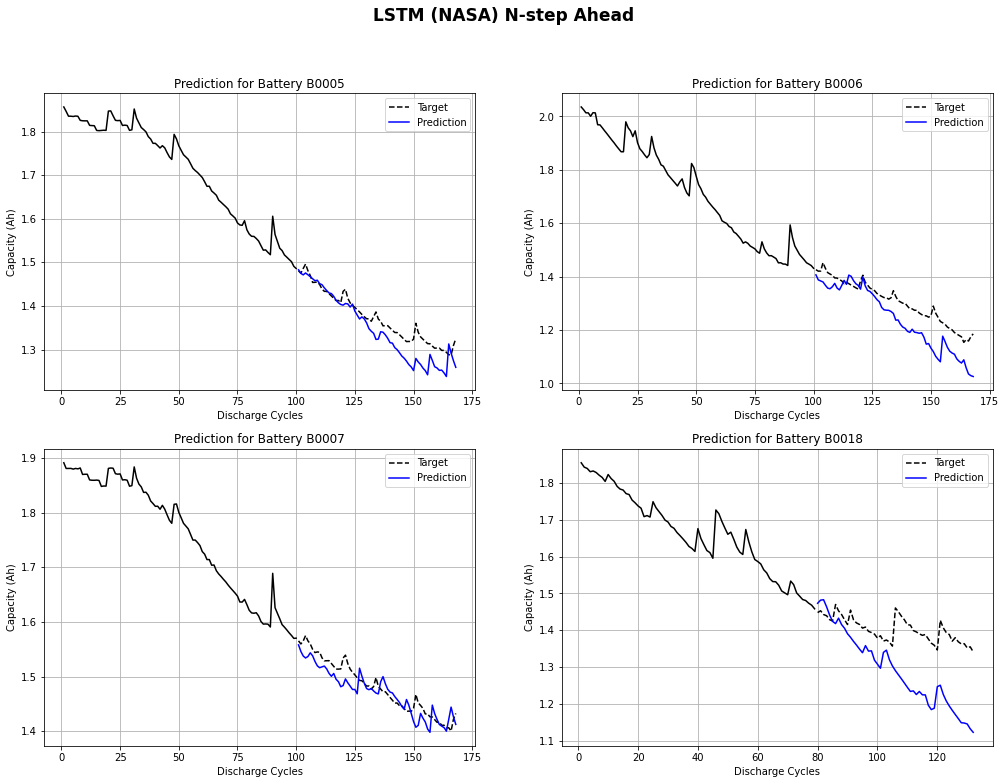

In [31]:
import matplotlib as mpl

final_output={}

plt.figure(figsize=(17,12))
plt.suptitle('LSTM (NASA) N-step Ahead',fontsize=17, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  final_output[leave_out] = {}
  model[leave_out].eval()
  output_len = len(x_test[leave_out][leave_out])
  outputs = np.empty((0,output_len))
  with torch.no_grad():
      xl = len(x_train[leave_out][leave_out])
      train_period = input_window
      dict_res = x_train[leave_out][leave_out]
      x = dict_res[xl-train_period: xl]   
       
      outputs_len = output_len + (output_window-(output_len%output_window))
      
      while len(outputs) < outputs_len:
          Y_test_pred = model[leave_out].predict(torch.from_numpy(x).type(torch.Tensor).to(device), target_len = output_window)
          outputs = np.concatenate((outputs, Y_test_pred), axis=None)
          x = x[output_window:output_window+input_window]
          x = np.append(x, [Y_test_pred])
          x = x.reshape(-1,1)
  new_outputs = outputs[0:output_len+1]
  if DETREND:
    denormalize = scaler[leave_out].inverse_transform(np.array(new_outputs).reshape(-1, 1))
    final_output[leave_out][leave_out] = retrend_function(Batt_Val=Battery, denormalize=denormalize, name=leave_out)
    final_output[leave_out][leave_out] = np.concatenate(final_output[leave_out][leave_out],axis=0)
  else:
    final_output[leave_out][leave_out] = new_outputs

  # Metrics
  x, y = Battery[leave_out]
  y_true = y[-len(final_output[leave_out][leave_out]):]
  y_preds = final_output[leave_out][leave_out]
  print(f"Metrics for Model Prediction on {leave_out}")
  acc = accuracy(np.array(y_true),np.array(y_preds))*100
  mae = mean_absolute_error(np.array(y_true),np.array(y_preds))
  rmse = sqrt(mean_squared_error(np.array(y_true),np.array(y_preds)))
  print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | Accuracy: {acc:.4f}%")
  print("-"*50)

  # Plot
  plt.subplot(2,2,idx+1)
  x, y = Battery[leave_out]

  plt.title(f'Prediction for Battery {leave_out}')
  plt.ylabel('Capacity (Ah)')
  plt.xlabel('Discharge Cycles')
  plt.grid(True)
  plt.plot(x[:-len(final_output[leave_out][leave_out])], y[:-len(final_output[leave_out][leave_out])], "k-")
  plt.plot(x[-len(final_output[leave_out][leave_out]):], y[-len(final_output[leave_out][leave_out]):], "k--", label='Target')
  plt.plot(x[-len(final_output[leave_out][leave_out]):], final_output[leave_out][leave_out], "b-", label='Prediction')
  plt.legend()
  
plt.savefig(f'One-Step_LSTM_NASA.pdf')